In [101]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
import random

In [80]:
#ODCZYT DANYCH Z PLIKU

#Funkcja odczytująca dane z plików csv w folderze Data
def ReadData(name:str):
    df = pd.read_csv("Data/"+name,header=None, sep=' ')
    Tasks=[]
    buf=[]
    for i in range(df.shape[0]):
        buf.clear()
        buf.append(i+1)
        for j in range(df.shape[1]):
            buf.append(df.iloc[i,j].item())
        Tasks.append(buf.copy())
    return Tasks
    

In [81]:
#FUNKCJE POMOCNICZE

#Funkcja oblicza wartości funkcji celu dla danego zestawu zadań.
#Argumenty:
#           Tasks - Czasy wykonywania zadań reprezentowane przez listę dwuwymiarową.
#                   Pierwszy indeks oznacza numer zadania, natomiast drugi indeks 
#                   oznacza numer maszyny.
#Zwracane:
#           S     - Macierz czasów rozpoczęcia wykonywanych zadań na maszynach. 
#                   Indeksowana w sposób S[zadanie][maszyna]
#           C     - Macierz czasów zakończenia wykonywanych zadań na maszynach. 
#                   Indeksowana w sposób C[zadanie][maszyna]
#           Cmax  - Maksymalny czas wykonywania wszystkich zadań.
#Funkcja przy liczeniu pomija pierwszy element każdego wektora czasów zadań, ponieważ jest on
#zarezerwowany dla numeru zadania.
def Calc_CMax(Tasks:list):
    C=np.zeros([len(Tasks[0])-1, len(Tasks)])
    S=np.zeros([len(Tasks[0])-1, len(Tasks)])
    #i -  maszyna, j - zadanie
    for i in range(0, len(Tasks[0])-1):
        for j in range(0, len(Tasks)):
            S[i,j] = max(C[i,j-1], C[i-1,j])
            C[i,j] = S[i,j] + Tasks[j][i+1]
    return S.transpose(), C.transpose(), C.max()

#Funkcja zamienia miejscami 2 elementy listy
#Argumenty:
#           Tasks - Lista z elementami. !!!Podając liste do funkcji należy użyc metody copy()
#           i, j  - Pozycje zamienianych argumentów na liście.
#Zwracane:
#           Tasks - Lista z zamienionymi elementami.
def Swap(Tasks:list, i:int, j:int):
    buffer1=Tasks[i]
    buffer2=Tasks[j]
    Tasks[i]=buffer2
    Tasks[j]=buffer1
    return Tasks


#Funkcja wyciągająca i-ty element listy i ustawiająca go na j-tej pozycji.
#Argumenty:
#           Tasks - Lista z elementami. !!!Podając liste do funkcji należy użyc metody copy()
#           i, j  - Pozycje zamienianych argumentów na liście.
#Zwracane:
#           bufList - Lista z zamienionymi elementami.
def Swap2(Tasks:list, i:int, j:int):  
    bufList=[]
    if i<j:
        l=j+1
    else:
        l=j
    for k in range(0, l):
        if (k is not i):
            bufList.append(Tasks[k])
    bufList.append(Tasks[i])
    for k in range(l, len(Tasks)):
        if (k is not i):
            bufList.append(Tasks[k])
    return bufList
    

#Funkcja służąca do zmniejszania zakazów na liście Tabu zrealizowanej w formie macierzy.
#Jej działanie polega na zmniejszeniu o jeden wartości większy od zera, co oznacza skrócenie
#zakazu danego ruchu.
#Argumenty:
#           Tabu - Macierz reprezentująca listę zakazów.
#Zwracane:
#           Tabu - Macierz zakazów ze zmniejszonymi ograniczeniami.
def TabuDecrement(Tabu):
    for i in range(Tabu.shape[0]):
        for j in range(Tabu.shape[1]):
            if Tabu[i,j] != 0:
                Tabu[i,j] += -1
    return Tabu

#Funkcja wyświetla permutację zadań (kolejność wykonywania zadań)
def PrintPermutation(Tasks:list):
    buffer=[]
    for i in range(len(Tasks)):
        buffer.append(Tasks[i][0]-1)
    print(buffer)


In [82]:
#ALGORTYM NEH

#Funkcja pomocnicza dla algorytmu NEH. Ma zadanie obliczanie wag zadań, 
#czyli sumy czasów wykonywania zadania na wszystkich maszynach.
#Argumenty:
#       Tasks       - Czasy wykonywania zadań reprezentowane przez listę dwuwymiarową.
#                     Indeksowanie takie samo jak przy pozostałych algorytmach.
#Zwraca:
#        weights    - Lista wag zadań (kolejność taka sama jak dla zadań).
def CalculateWeights(Tasks:list):
    weights=[]
    for i in range(len(Tasks)):
        weights.append(np.array(Tasks[i][1:]).sum())
    return weights

#Funkcja za ma zadanie dodanie do aktualnej permutacji nowe zadanie w taki sposób,
# że wartość funkcji celu dla nowej permutacji będzie jak najmniejsza.
#Argumenty:
#       Tasks       - Aktualna permutacja
#       NewTasks    - Nowe zadanie
#Zwraca:
#       permutation - Znaleziona najlepsza permutacja
def FindBestPosition(Tasks:list, NewTask:list):
    permutation=[]
    bestPermutation=[]
    CMax=float('inf')
    bestCMax=float('inf')
    
    #Sprawdzenie każdej dowolnej pozycji
    for i in range(len(Tasks)+1):
        permutation.clear()
        
        #Utworzenie permutacji z zadaniem dodanym na konkretnej pozycji
        for j in range(len(Tasks)):
            if j==i:
                permutation.append(NewTask.copy())
            permutation.append(Tasks[j].copy())
        #WYJĄTEK nowe zadanie na końcu permutacji
        if i == (len(Tasks)):
            permutation.append(NewTask.copy())
        
        #Obliczenie wartości funkcji celu nowej permutacji
        S, C, CMax=Calc_CMax(permutation.copy())
        #Zapamiętanie najlpeszego rozwiązania
        if CMax < bestCMax:
            bestCMax=CMax
            bestPermutation=permutation.copy()
    
    return bestPermutation
  
#Implementacja algorytmu NEH, który ma za zadanie znalezienie jak najlepszej 
# permutacji wykonywania zadań dla problemu przepływowego.
#Argumenty:
#       Tasks       - Czasy wykonywania zadań reprezentowane przez listę dwuwymiarową.
#                     Pierwszy indeks oznacza numer zadania, natomiast drugi indeks 
#                     oznacza numer maszyny (wyjątek: pierwszy element każdego zadania to jego numer,
#                     a nie czas wykonywania na pierwszej maszynie).
#Zwraca:
#       permutation - Znaleziona permutacja.
def NEH(Tasks:list):
    permutation=[]
    #Obliczenie wag zadań
    listOfWeights=CalculateWeights(Tasks.copy())      
    
    #Sortowanie zadań
    zippedTasks = sorted(zip(listOfWeights, Tasks.copy()), key=lambda x: x[0], reverse=True)
    
    #Tworzenie najlepszej permutacji
    permutation.append(zippedTasks[0][1])
    for i in range(1, len(zippedTasks)):
        permutation=FindBestPosition(permutation.copy(), zippedTasks[i][1].copy())

    return permutation

In [83]:
#ALGORYTM TABU SEARCH

# Pierwsza wersja algortymu tabu search. Zaimplementowano w niej listę zakazów (w postaci macierzy) 
# oraz funkcję aspiracji w postaci akceptowania zakazanego ruchu, gdy da on lepszą permutancję niż 
# aktualnie najlepsza.
# Argumenty:
#           Tasks           - Czasy wykonywania zadań reprezentowane przez listę dwuwymiarową.
#                           Pierwszy indeks oznacza numer zadania, natomiast drugi indeks 
#                           oznacza numer maszyny (wyjątek: pierwszy element każdego zadania to jego numer,
#                           a nie czas wykonywania na pierwszej maszynie).
#           epochs_max      - Maksymalna liczba powtórzeń algorytmu.
#           tabuValue       - Długość listy zakazów. Wartość definiuje przez ile kolejnych 
#                           przeszukiwań dany ruch będzie zakazany.
#           stopRepeat      - Liczba powtórzeń poszukiwań, po której algorytm zostanie zatrzymany, 
#                           gdy nie zostanie znalezione lepsze rozwiązanie.
#           aspiration      - Dla wartości True działa funkcja aspiracji.
#           neighboursType  - Metoda generowania sąsiedztwa:
#                               *1 - Metoda par dowolnych
#                               *2 - Metoda par przyległych
#                               *3 - Technika przenoszenia i wstawiania
# Zwracane:
#           bestPermutation - Najlepsza znaleziona permutacja, która daje możliwe 
#                             jak najniższą wartość funkcji celu.
def TabuSearch(Tasks:list, epochs_max:int, tabuValue=7, stopRepeat=25, aspiration=False, neighboursType=1):

    
    #Inicjalizacja zmiennych
    tabu=np.zeros([len(Tasks), len(Tasks)])
    permutation=NEH(Tasks.copy())
    S, C, cmax = Calc_CMax(permutation.copy())
    bestPermutation=permutation.copy()
    bestCMax= cmax
    neighbours=[]
    repeat=0
    nn=0
    cmax_epochs=[]

    
    #Warunek stopu
    for n in range(epochs_max):
        repeat+=1
        
        #Zmniejszenie zakazów
        tabu = TabuDecrement(tabu)
        
        #Generowanie sąsiadów
        neighbours.clear()
        for i in range(len(Tasks)):
        
            #Wymiana par dowolnych
            if neighboursType == 1:
                for j in range(i+1, len(Tasks)):
                    bufPermutation=Swap(permutation.copy(), i, j)
                    empty1, empty2, cmax=Calc_CMax(bufPermutation.copy())
                    buf=[i, j, cmax]
                    neighbours.append(buf.copy())
            
                        
            #Wymiana par przyległych
            if neighboursType == 2:
                if i < len(Tasks)-1:
                    bufPermutation=Swap(permutation.copy(), i, i+1)
                    empty1, empty2, cmax=Calc_CMax(bufPermutation.copy())
                    buf=[i, i+1, cmax]
                    neighbours.append(buf.copy())
                    
            #Technika przenoszenia i wstawiania
            if neighboursType == 3:
                for j in range(len(Tasks)):
                    if(i is not j) & (i is not j+1):
                        bufPermutation=Swap2(permutation.copy(), i, j)
                        empty1, empty2, cmax=Calc_CMax(bufPermutation.copy())
                        buf=[i, j, cmax]
                        neighbours.append(buf.copy())
                    
                    
        #Sortowanie sąsiadów 
        neighbours=sorted(neighbours, key=lambda x: x[2])
        
        
        #Sprawdzanie listy tabu
        for k in range(len(neighbours)):
            a, b, cmax = neighbours[k]
            #Przeliczenie pozycji na liście na numery zadań
            i = permutation[a][0]-1
            j = permutation[b][0]-1
            #Wybór dozwolonego ruchu
            if tabu[i,j]==0:
                #Dla metód wymiany par dowolonych i wymiany par przyległych operacje swap(i,j) i swap(j,i) są równoważne,
                #a nałożenie operacji swap(i,j) na wynik operacji(i,j) znosi działanie operacji i tworzony jest cykl.
                #Dlatego należy zakazać operacji swap(i,j) i swap(j,i) po wykonaniu operacji(i,j)
                if (neighboursType == 1) | (neighboursType == 2):
                    tabu[i,j]=tabuValue
                    tabu[j,i]=tabuValue
                #Dla techniki przenoszenia i wstawianie operacje swap(i,j) i swap(j,i) nie są równoważne i dają różne efekty,
                #jednak nałożenie operacji swap(j,i) na wynik operacji swap(i,j), znosi działanie pierwotnie wykonanej operacji,
                #co powoduje utworzeniu cyklu. Z tego powodu po wykonaniu operacji swap(i,j) należy zakazać wykonania operacji
                #swap(j,i). Wyjątkiem od tej reguły jest przypadek gdy j=i+1 lub j=i-1. W tym przypadku swap(i,j) jest równoważne
                #operacji swap(j,i), a więc w tym przypadku należy zabronić wykania obu operacji.
                if (neighboursType == 3):
                    tabu[j,i]=tabuValue
                    if abs(a-b) == 1:
                        tabu[i,j]=tabuValue
                #Wymiana par dowolnych lub par przyległych
                if (neighboursType == 1) | (neighboursType == 2):
                    permutation=Swap(permutation.copy(), a, b)
                #Technika przenoszenia i wstawiania
                if neighboursType == 3:
                    permutation=Swap2(permutation.copy(), a, b)
                if cmax<bestCMax:
                    bestCMax=cmax
                    bestPermutation=permutation.copy()
                    repeat=0
                break
            #Aspiracja - wykonujemy zakazany ruch, gdy da rozwiązanie lepsze niż najlepsze aktualnie znalezione
            elif cmax<bestCMax:
                if aspiration:
                    if (neighboursType == 1) | (neighboursType == 2):
                        tabu[i,j]=tabuValue
                        tabu[j,i]=tabuValue
                    if (neighboursType == 3):
                        tabu[j,i]=tabuValue
                        if abs(a-b) == 1:
                            tabu[i,j]=tabuValue
                    #Wymiana par dowolnych lub par przyległych
                    if (neighboursType == 1) | (neighboursType == 2):
                        permutation=Swap(permutation.copy(), a, b)
                    #Technika przenoszenia i wstawiania
                    if neighboursType == 3:
                        permutation=Swap2(permutation.copy(), a, b)
                    bestCMax=cmax
                    bestPermutation=permutation.copy()
                    repeat=0
                    break
        cmax_epochs.append(cmax)
        #Sprawdzenie czy permutacja się powtarza
        
        if repeat==stopRepeat:
            nn=n+1
            break
        
    #MOŻLIWE SPOSOBY KOŃCZENIA ALGORYTMU
    #-Określona liczba powtórzeń
    #-Zakończenie gdy znajdowana wartość funkcji celu się powtarza (średnio działa dla tego problemu)
    #-Kończenie gdy przez N powtórzeń nie znajdzie się lepsze rozwiązanie (Aktualnie zaimplementowane)
        
        
    #Zwrócenie najlepszego rozwiązania
    return bestPermutation.copy() , cmax_epochs #,nn

                

In [109]:
#ALGORYTM BRANCH AND BOUND
#Ze wzgledu na to, że algorytm branch and bound jest algorytmem dokładnym i czas jego wykonywania dla naszego problemu jest 
#bardzo długi podpieramy się wcześniej zaimplementowanym algorytmem NEH tak, jak zostało to wykorzystane w implementacji
#TabuSearch'a. Dodatkowo algorytm posiada ograniczenie czasowe do 20 minut wykonywania.


#WERSJA 1 I 2 BEZ NEH -> DETERMINISTYCZNA I LOSOWA PERMUTACJA

# Deterministyczna permutacja jest szybka i przewidywalna, ale może nie być efektywna w eksploracji 
# przestrzeni rozwiązań, jeśli naturalny porządek zadań nie jest bliski optymalnemu.

# Losowa permutacja może lepiej eksplorować przestrzeń rozwiązań, ale wyniki będą różnić się przy 
# każdym uruchomieniu, co może wpływać na konsekwencję wyników.

def BranchAndBound(tasks, max_time=1200):
    start_time = time.time()

    # Początkowa permutacja zadań (prosta sekwencja indeksów)
    initial_perm = list(range(len(tasks)))
    #WERSJA 2 -> LOSOWA PERMUTACJA
    # random.shuffle(initial_perm)

    # Obliczenie C_max dla tej permutacji zadań
    initial_cmax = Calc_CMax([tasks[i] for i in initial_perm])[2]
    best_perm = initial_perm
    min_cmax = initial_cmax
    cmax_history = [initial_cmax]

    heap = []
    all_jobs_indices = set(range(len(tasks)))
    remaining_jobs = all_jobs_indices - set(initial_perm)
    heappush(heap, (min_cmax, initial_perm, remaining_jobs))

    while heap and time.time() - start_time < max_time:
        _, current_perm, remaining_jobs = heappop(heap)

        if not remaining_jobs:
            current_cmax = Calc_CMax([tasks[i] for i in current_perm])[2]
            cmax_history.append(current_cmax)
            if current_cmax < min_cmax:
                min_cmax = current_cmax
                best_perm = current_perm
        else:
            for job in remaining_jobs:
                new_perm = current_perm + [job]
                new_perm_cmax = Calc_CMax([tasks[i] for i in new_perm])[2]
                cmax_history.append(new_perm_cmax)
                if new_perm_cmax <= min_cmax:
                    new_remaining_jobs = remaining_jobs - {job}
                    heappush(heap, (new_perm_cmax, new_perm, new_remaining_jobs))

    return [tasks[i] for i in best_perm], min_cmax, cmax_history



#WERSJA 3 -> WYKORZYSTUJEMY NEH
def BranchAndBoundWithNEH(tasks, max_time=1200):  # 1200 seconds = 20 minutes
    start_time = time.time()

    initial_perm = NEH(tasks)
    initial_cmax = Calc_CMax(initial_perm)[2]
    best_perm = initial_perm
    min_cmax = initial_cmax
    cmax_history = [initial_cmax]

    heap = []
    all_jobs_indices = set(range(len(tasks)))
    initial_job_indices = {tasks.index(task) for task in initial_perm if task in tasks}
    remaining_jobs = all_jobs_indices - initial_job_indices
    heappush(heap, (min_cmax, initial_perm, remaining_jobs))

    while heap and time.time() - start_time < max_time:
        current_cmax, current_perm, remaining_jobs = heappop(heap)

        if not remaining_jobs:
            current_cmax = Calc_CMax(current_perm)[2]
            cmax_history.append(current_cmax)
            if current_cmax < min_cmax:
                min_cmax = current_cmax
                best_perm = current_perm
        else:
            # Wyłącznie wstawianie nowych permutacji, które mają potencjał bycia lepszymi
            for job in remaining_jobs:
                new_perm = current_perm + [tasks[job]]
                new_perm_cmax = Calc_CMax(new_perm)[2]
                cmax_history.append(new_perm_cmax)
                # Dodajemy nową permutację do kopca tylko jeśli jej C_max jest lepszy niż obecny min_cmax
                if new_perm_cmax <= min_cmax:
                    new_remaining_jobs = remaining_jobs - {job}
                    heappush(heap, (new_perm_cmax, new_perm, new_remaining_jobs))

    return best_perm, min_cmax, cmax_history


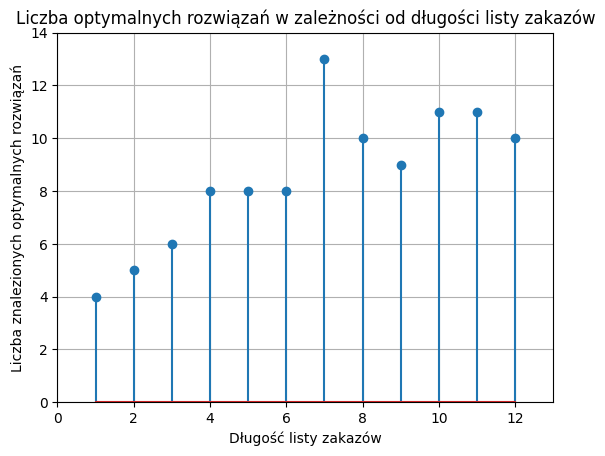

In [84]:
#BADANIE 1
#DOBÓR DŁUGOŚCI LISTY TABU
#Badanie ma na celu znalezienie jak najlepszej długości listy zakazu. 
# Na potrzeby tego wyłączono działanie funkcji aspiracji oraz ustalono liczbę powtórzen alogrytmu
'''
epochs=100
tabuValue= np.arange(12)+1
csv_file = open('Badania1.csv', 'w')
for i in range(1, 23):
    data = ReadData("data."+str(i))
    print("Przetwarzanie pliku data."+str(i))
    perm = NEH(data)
    S, C, cmax = Calc_CMax(perm)
    results = str(cmax)
    print("Algorytm NEH: Cmax="+str(cmax))
    for j in range(len(tabuValue)):
        perm = TabuSearch(data, 100, tabuValue[j], 0)
        S, C, cmax = Calc_CMax(perm)
        results += " "+str(cmax)
        print("Algorytm TabuSearch przy liście tabu o długości="+str(tabuValue[j])+" : Cmax="+str(cmax))
    csv_file.writelines(results+"\n")
    print(results)

csv_file.close()
'''

#WYNIK BADAŃ NAJLEPSZE EFEKTY DLA LISTY TABU O DŁUGOŚCI 7

result1 = [4,5,6,8,8,8,13,10,9,11,11,10]
plt.figure()
plt.stem(range(1,len(result1)+1), result1)
plt.xlabel("Długość listy zakazów")
plt.ylabel("Liczba znalezionych optymalnych rozwiązań")
plt.title("Liczba optymalnych rozwiązań w zależności od długości listy zakazów")
plt.axis([0,13,0,14])
plt.grid()




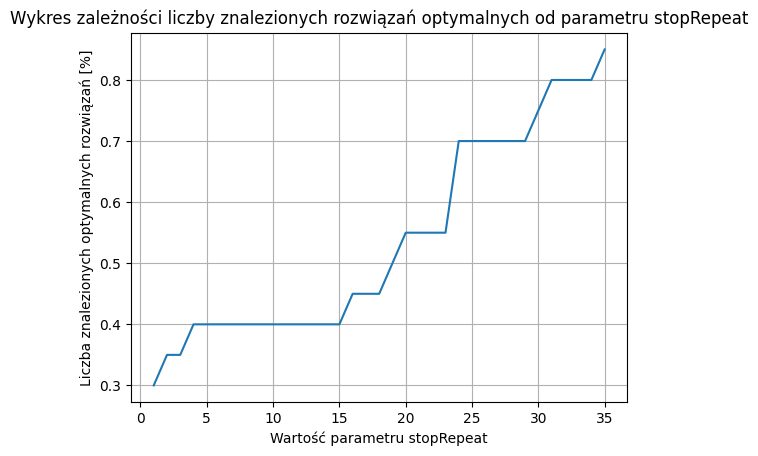

In [85]:
#BADANIE 2
#DOBÓR LICZBY POWTÓRZEŃ ALGORYTMU
#Badanie ma na celu wyznaczenie optymalnej wartości liczby powtórzeń algorytmu. 
# Pierwszą opcją jest z góry ustalona liczba powtórzeń, jednak jej minusem jest 
# trudność w oszacowaniu odpowiedniej liczby dla zestawu danych. Innym warunkiem 
# stopu może być brak znalezienia lepszego rozwiązania od dotychczasowego przez N 
# powtórzeń. W tym celu w tym badaniu sprawdzono jakie wartości N są najlepsze do 
# posiadanych zestawów danych. Podczas badania korzystano z wcześniej wyznaczonej 
# długości listy tabu i jednocześnie nie korzystano z funkcji aspiracji.

'''
epochs=1000
tabuValue=7
N= np.arange(36)+1

csv_file = open('Badania2.csv', 'w')
for i in range(1, 21):
    data = ReadData("data."+str(i))
    print("Przetwarzanie pliku data."+str(i))
    perm = NEH(data)
    S, C, cmax = Calc_CMax(perm)
    results = str(cmax)
    print("Algorytm NEH: Cmax="+str(cmax))
    for j in range(len(N)):
        perm, n= TabuSearch(data, epochs, tabuValue, N[j])
        S, C, cmax = Calc_CMax(perm)
        results += " "+str(cmax)+" "+str(n)
        print("Algorytm TabuSearch przy N="+str(N[j])+" : Cmax="+str(cmax)+" n= "+str(n))
    csv_file.writelines(results+"\n")
    print(results)

csv_file.close()
'''

#WYNIK BADAŃ: Najlepiej przyjmować liczbę powtórzeń algortmu >25

result2=[6,7,7,8,8,8,8,8,8,8,8,8,8,8,8,9,9,9,10,11,11,11,11,14,14,14,14,14,14,15,16,16,16,16,17]
result2=[i/20.0 for i in result2]
plt.figure()
plt.plot(range(1,len(result2)+1), result2)
plt.xlabel("Wartość parametru stopRepeat")
plt.ylabel("Liczba znalezionych optymalnych rozwiązań [%]")
plt.title("Wykres zależności liczby znalezionych rozwiązań optymalnych od parametru stopRepeat")
#plt.axis([0,13,0,14])
plt.grid()



In [86]:
#BADANIE 3
#PORÓWNANIE WPŁYWU FUNKCJI ASPIRACJI
#1 - aspiracja
#2 - bez aspiracji
'''
max_epochs=100
tabuValue= 7
epochs=25
buffer1=[]
buffer2=[]
for i in range(1, 11):
    data = ReadData("data."+str(i))
    buffer1.clear()
    buffer2.clear()
    perm, buffer1 = TabuSearch(data, max_epochs, tabuValue, epochs, True)
    perm, buffer2 = TabuSearch(data, max_epochs, tabuValue, epochs, False)
    plt.figure()
    plt.plot(range(1,len(buffer1)+1), buffer1)
    plt.plot(range(1,len(buffer2)+1), buffer2, linestyle='--')
    plt.title("Badanie wpływu funkcji aspiracji na działanie algorytmu")
    plt.legend(["Algorytm z aspiracją", "Algorytm bez aspiracji"])
    plt.xlabel("Liczba powtórzeń algorytmu")
    plt.ylabel("Wartość funkcji celu cmax")
    plt.grid()
    plt.show()
'''


'\nmax_epochs=100\ntabuValue= 7\nepochs=25\nbuffer1=[]\nbuffer2=[]\nfor i in range(1, 11):\n    data = ReadData("data."+str(i))\n    buffer1.clear()\n    buffer2.clear()\n    perm, buffer1 = TabuSearch(data, max_epochs, tabuValue, epochs, True)\n    perm, buffer2 = TabuSearch(data, max_epochs, tabuValue, epochs, False)\n    plt.figure()\n    plt.plot(range(1,len(buffer1)+1), buffer1)\n    plt.plot(range(1,len(buffer2)+1), buffer2, linestyle=\'--\')\n    plt.title("Badanie wpływu funkcji aspiracji na działanie algorytmu")\n    plt.legend(["Algorytm z aspiracją", "Algorytm bez aspiracji"])\n    plt.xlabel("Liczba powtórzeń algorytmu")\n    plt.ylabel("Wartość funkcji celu cmax")\n    plt.grid()\n    plt.show()\n'

Przetwarzanie pliku data.1
Algorytm NEH: Cmax=2782.0
Algorytm TabuSearch przy type sąsiedztwa nr=1 : Cmax=2762.0, Czas wykonywania algorytmu: 12.802649021148682s
Algorytm TabuSearch przy type sąsiedztwa nr=2 : Cmax=2782.0, Czas wykonywania algorytmu: 0.6203062534332275s
Algorytm TabuSearch przy type sąsiedztwa nr=3 : Cmax=2768.0, Czas wykonywania algorytmu: 20.914942026138306s


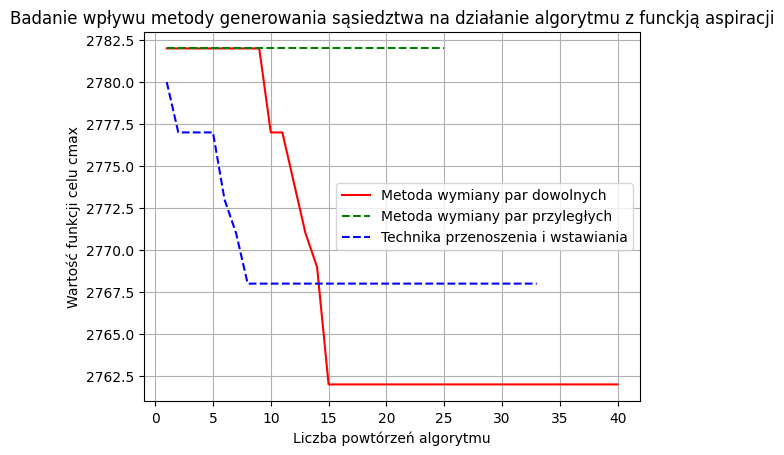

Przetwarzanie pliku data.2
Algorytm NEH: Cmax=2868.0
Algorytm TabuSearch przy type sąsiedztwa nr=1 : Cmax=2864.0, Czas wykonywania algorytmu: 8.625924825668335s
Algorytm TabuSearch przy type sąsiedztwa nr=2 : Cmax=2868.0, Czas wykonywania algorytmu: 0.6679065227508545s
Algorytm TabuSearch przy type sąsiedztwa nr=3 : Cmax=2864.0, Czas wykonywania algorytmu: 15.8528892993927s


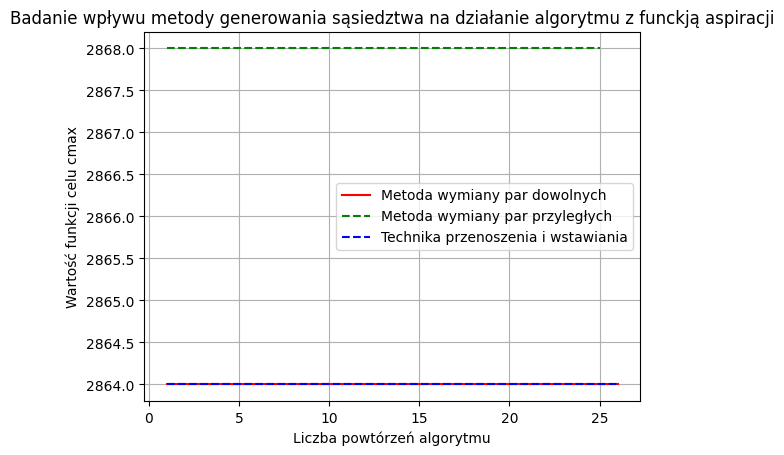

Przetwarzanie pliku data.3
Algorytm NEH: Cmax=2850.0
Algorytm TabuSearch przy type sąsiedztwa nr=1 : Cmax=2836.0, Czas wykonywania algorytmu: 8.526942729949951s
Algorytm TabuSearch przy type sąsiedztwa nr=2 : Cmax=2850.0, Czas wykonywania algorytmu: 0.5409636497497559s
Algorytm TabuSearch przy type sąsiedztwa nr=3 : Cmax=2836.0, Czas wykonywania algorytmu: 17.388436794281006s


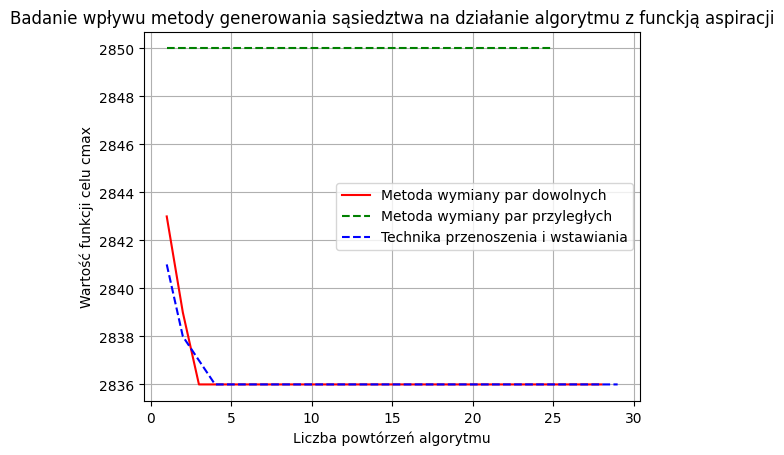

Przetwarzanie pliku data.4
Algorytm NEH: Cmax=1159.0
Algorytm TabuSearch przy type sąsiedztwa nr=1 : Cmax=1081.0, Czas wykonywania algorytmu: 1.2322566509246826s
Algorytm TabuSearch przy type sąsiedztwa nr=2 : Cmax=1142.0, Czas wykonywania algorytmu: 0.07452511787414551s
Algorytm TabuSearch przy type sąsiedztwa nr=3 : Cmax=1100.0, Czas wykonywania algorytmu: 1.5067856311798096s


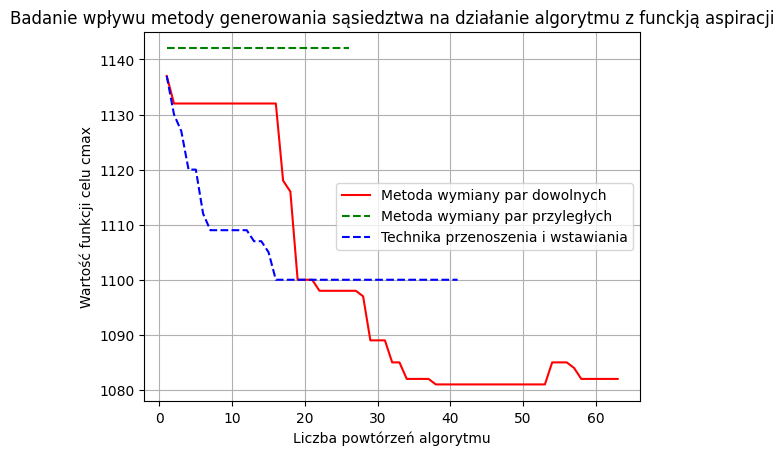

Przetwarzanie pliku data.5
Algorytm NEH: Cmax=1325.0
Algorytm TabuSearch przy type sąsiedztwa nr=1 : Cmax=1301.0, Czas wykonywania algorytmu: 1.5867455005645752s
Algorytm TabuSearch przy type sąsiedztwa nr=2 : Cmax=1323.0, Czas wykonywania algorytmu: 0.11234116554260254s
Algorytm TabuSearch przy type sąsiedztwa nr=3 : Cmax=1302.0, Czas wykonywania algorytmu: 1.531580924987793s


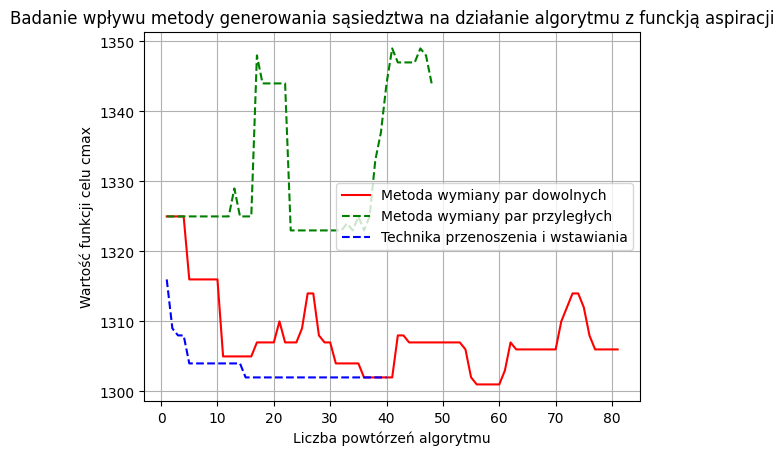

Przetwarzanie pliku data.6
Algorytm NEH: Cmax=1305.0
Algorytm TabuSearch przy type sąsiedztwa nr=1 : Cmax=1277.0, Czas wykonywania algorytmu: 0.5262184143066406s
Algorytm TabuSearch przy type sąsiedztwa nr=2 : Cmax=1305.0, Czas wykonywania algorytmu: 0.06641936302185059s
Algorytm TabuSearch przy type sąsiedztwa nr=3 : Cmax=1258.0, Czas wykonywania algorytmu: 0.9898290634155273s


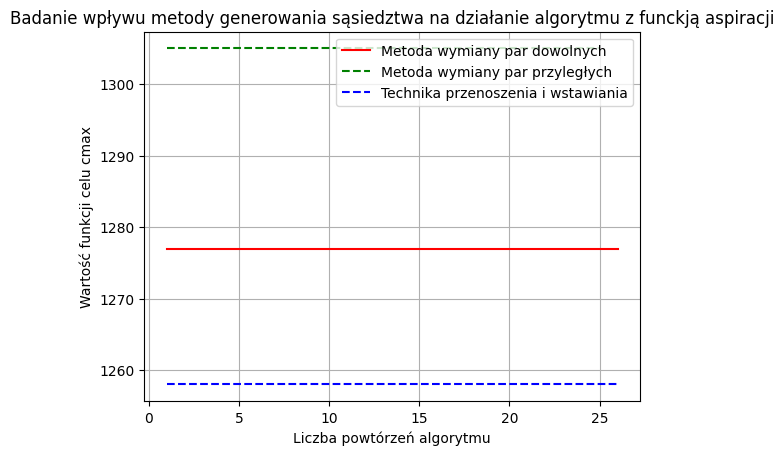

Przetwarzanie pliku data.7
Algorytm NEH: Cmax=1228.0
Algorytm TabuSearch przy type sąsiedztwa nr=1 : Cmax=1224.0, Czas wykonywania algorytmu: 0.5888063907623291s
Algorytm TabuSearch przy type sąsiedztwa nr=2 : Cmax=1224.0, Czas wykonywania algorytmu: 0.07856225967407227s
Algorytm TabuSearch przy type sąsiedztwa nr=3 : Cmax=1210.0, Czas wykonywania algorytmu: 1.5326828956604004s


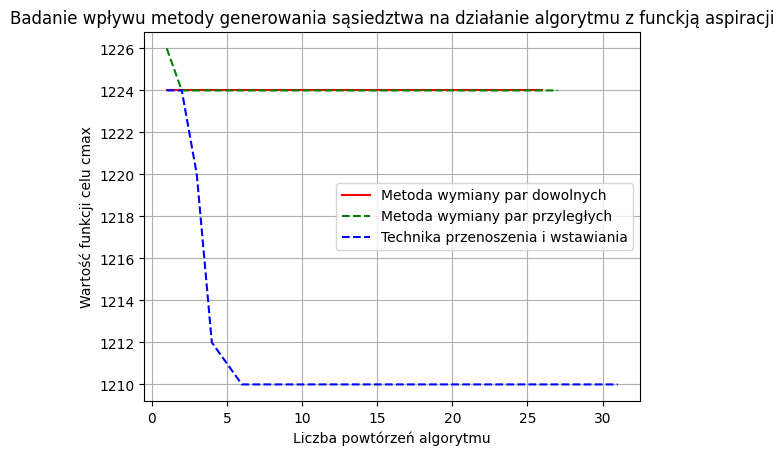

Przetwarzanie pliku data.8
Algorytm NEH: Cmax=1278.0
Algorytm TabuSearch przy type sąsiedztwa nr=1 : Cmax=1251.0, Czas wykonywania algorytmu: 0.6498849391937256s
Algorytm TabuSearch przy type sąsiedztwa nr=2 : Cmax=1251.0, Czas wykonywania algorytmu: 0.07667994499206543s
Algorytm TabuSearch przy type sąsiedztwa nr=3 : Cmax=1251.0, Czas wykonywania algorytmu: 1.6999132633209229s


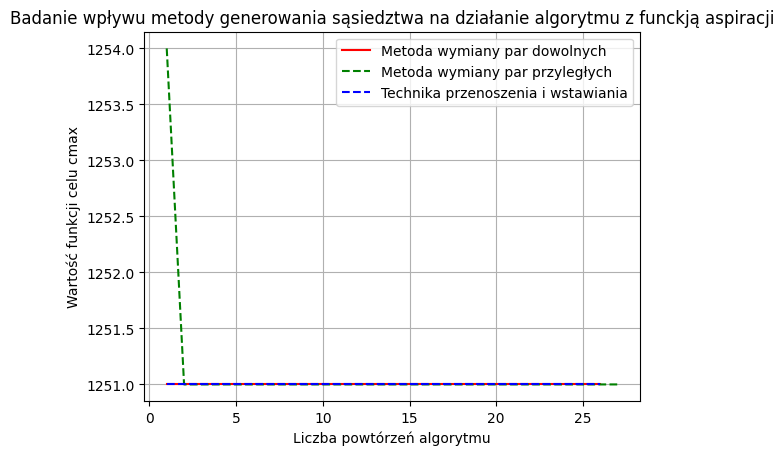

Przetwarzanie pliku data.9
Algorytm NEH: Cmax=1223.0
Algorytm TabuSearch przy type sąsiedztwa nr=1 : Cmax=1207.0, Czas wykonywania algorytmu: 0.8807964324951172s
Algorytm TabuSearch przy type sąsiedztwa nr=2 : Cmax=1215.0, Czas wykonywania algorytmu: 0.14248180389404297s
Algorytm TabuSearch przy type sąsiedztwa nr=3 : Cmax=1212.0, Czas wykonywania algorytmu: 1.2318096160888672s


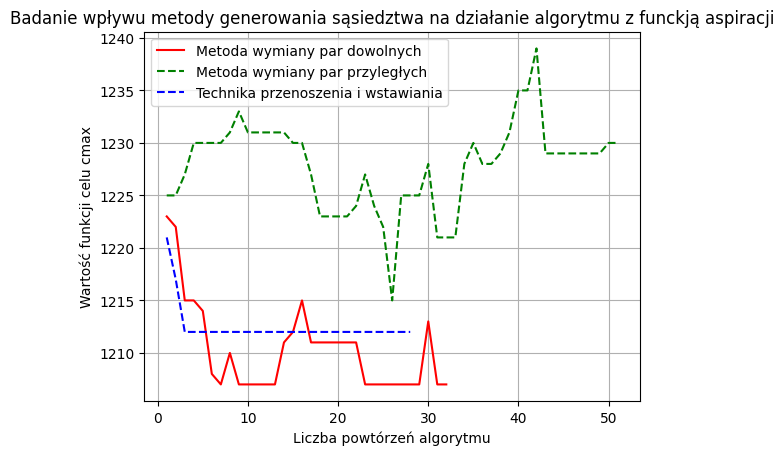

Przetwarzanie pliku data.10
Algorytm NEH: Cmax=1291.0
Algorytm TabuSearch przy type sąsiedztwa nr=1 : Cmax=1253.0, Czas wykonywania algorytmu: 1.3682994842529297s
Algorytm TabuSearch przy type sąsiedztwa nr=2 : Cmax=1284.0, Czas wykonywania algorytmu: 0.09319567680358887s
Algorytm TabuSearch przy type sąsiedztwa nr=3 : Cmax=1273.0, Czas wykonywania algorytmu: 1.4342045783996582s


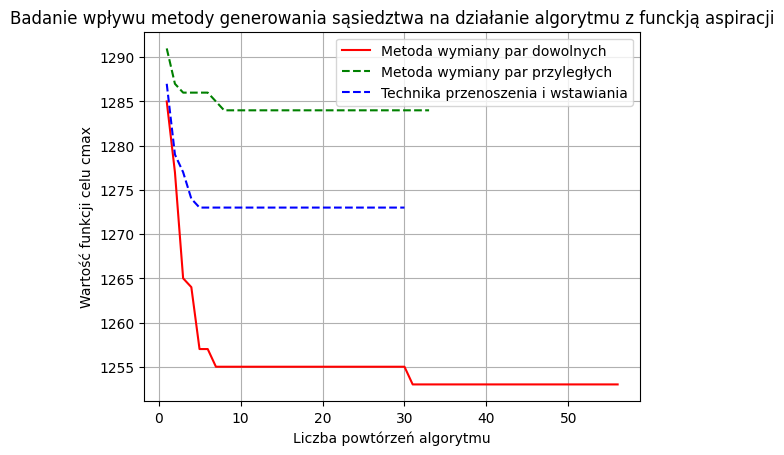

Przetwarzanie pliku data.11
Algorytm NEH: Cmax=1680.0
Algorytm TabuSearch przy type sąsiedztwa nr=1 : Cmax=1590.0, Czas wykonywania algorytmu: 3.3795430660247803s
Algorytm TabuSearch przy type sąsiedztwa nr=2 : Cmax=1640.0, Czas wykonywania algorytmu: 0.304546594619751s
Algorytm TabuSearch przy type sąsiedztwa nr=3 : Cmax=1586.0, Czas wykonywania algorytmu: 3.189701557159424s


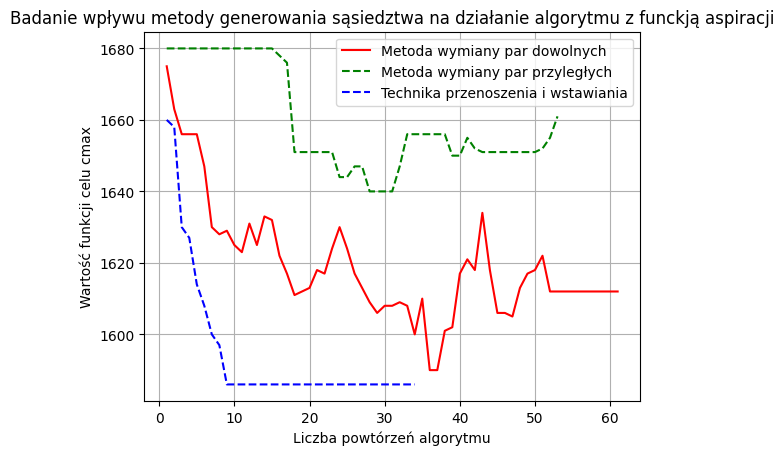

Przetwarzanie pliku data.12
Algorytm NEH: Cmax=1729.0
Algorytm TabuSearch przy type sąsiedztwa nr=1 : Cmax=1720.0, Czas wykonywania algorytmu: 1.4814636707305908s
Algorytm TabuSearch przy type sąsiedztwa nr=2 : Cmax=1724.0, Czas wykonywania algorytmu: 0.2561821937561035s
Algorytm TabuSearch przy type sąsiedztwa nr=3 : Cmax=1691.0, Czas wykonywania algorytmu: 4.885240793228149s


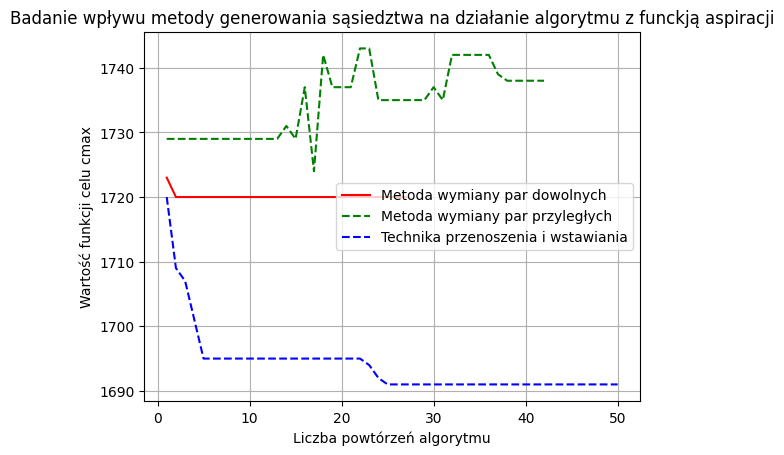

Przetwarzanie pliku data.13
Algorytm NEH: Cmax=2349.0
Algorytm TabuSearch przy type sąsiedztwa nr=1 : Cmax=2250.0, Czas wykonywania algorytmu: 7.868077516555786s
Algorytm TabuSearch przy type sąsiedztwa nr=2 : Cmax=2320.0, Czas wykonywania algorytmu: 0.24251937866210938s
Algorytm TabuSearch przy type sąsiedztwa nr=3 : Cmax=2267.0, Czas wykonywania algorytmu: 4.6528472900390625s


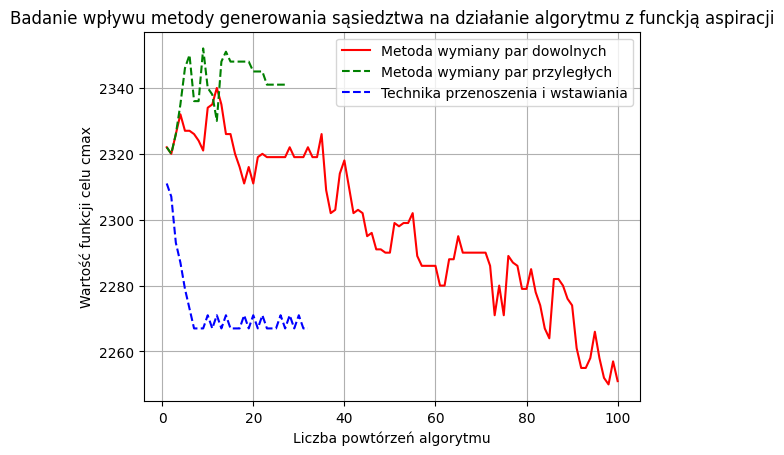

Przetwarzanie pliku data.14
Algorytm NEH: Cmax=2362.0
Algorytm TabuSearch przy type sąsiedztwa nr=1 : Cmax=2309.0, Czas wykonywania algorytmu: 7.350730895996094s
Algorytm TabuSearch przy type sąsiedztwa nr=2 : Cmax=2362.0, Czas wykonywania algorytmu: 0.22503185272216797s
Algorytm TabuSearch przy type sąsiedztwa nr=3 : Cmax=2309.0, Czas wykonywania algorytmu: 4.617747068405151s


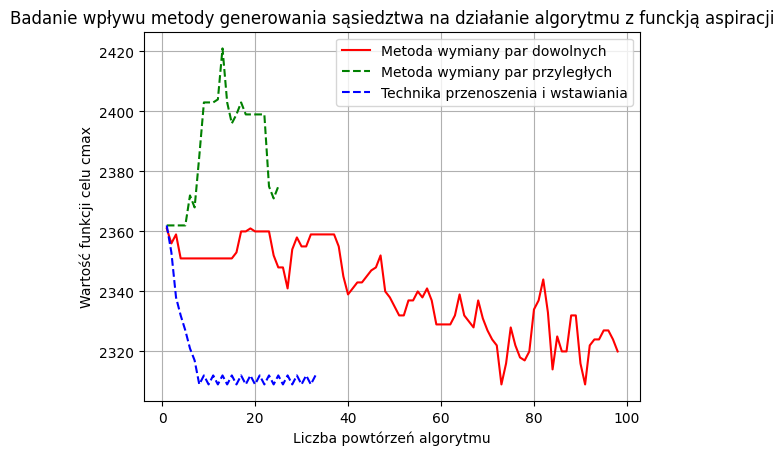

Przetwarzanie pliku data.15
Algorytm NEH: Cmax=2640.0
Algorytm TabuSearch przy type sąsiedztwa nr=1 : Cmax=2621.0, Czas wykonywania algorytmu: 8.664292335510254s
Algorytm TabuSearch przy type sąsiedztwa nr=2 : Cmax=2640.0, Czas wykonywania algorytmu: 0.5162882804870605s
Algorytm TabuSearch przy type sąsiedztwa nr=3 : Cmax=2621.0, Czas wykonywania algorytmu: 18.0585720539093s


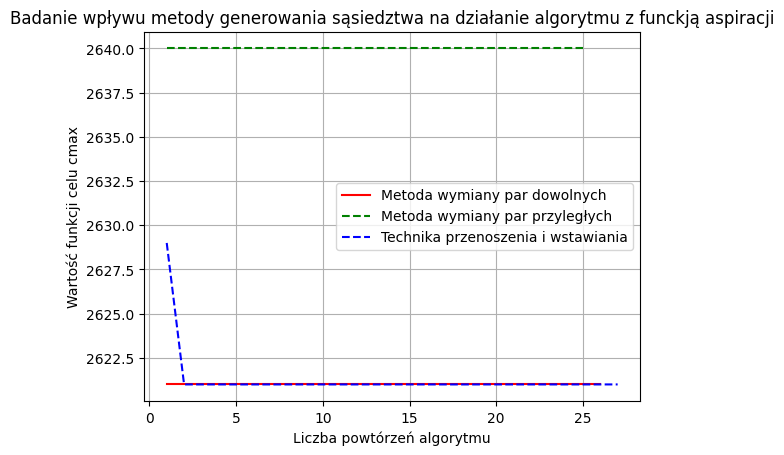

Przetwarzanie pliku data.16
Algorytm NEH: Cmax=2758.0
Algorytm TabuSearch przy type sąsiedztwa nr=1 : Cmax=2732.0, Czas wykonywania algorytmu: 10.646675825119019s
Algorytm TabuSearch przy type sąsiedztwa nr=2 : Cmax=2745.0, Czas wykonywania algorytmu: 0.614105224609375s
Algorytm TabuSearch przy type sąsiedztwa nr=3 : Cmax=2732.0, Czas wykonywania algorytmu: 21.89484667778015s


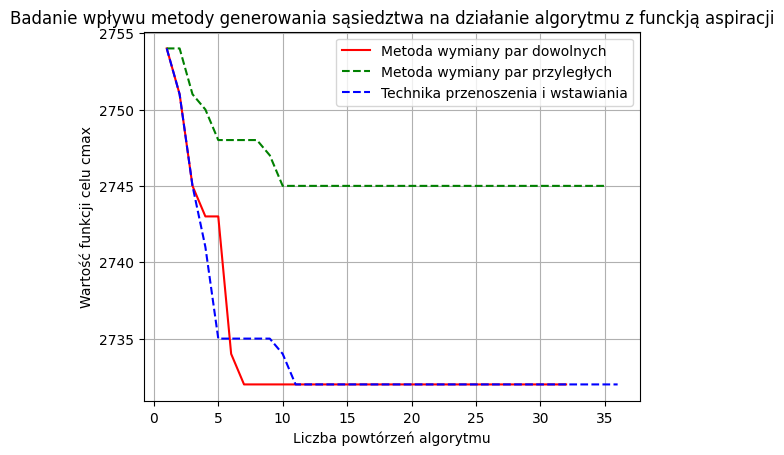

Przetwarzanie pliku data.17
Algorytm NEH: Cmax=2721.0
Algorytm TabuSearch przy type sąsiedztwa nr=1 : Cmax=2686.0, Czas wykonywania algorytmu: 10.248677968978882s
Algorytm TabuSearch przy type sąsiedztwa nr=2 : Cmax=2718.0, Czas wykonywania algorytmu: 0.5325565338134766s
Algorytm TabuSearch przy type sąsiedztwa nr=3 : Cmax=2686.0, Czas wykonywania algorytmu: 20.90175199508667s


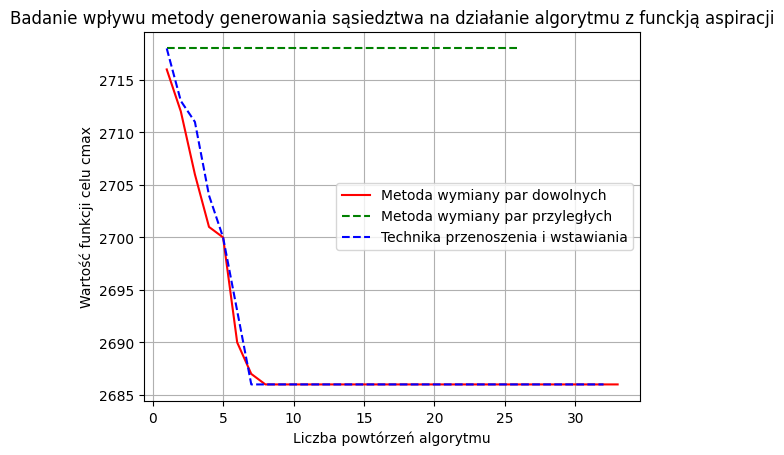

Przetwarzanie pliku data.18
Algorytm NEH: Cmax=3135.0
Algorytm TabuSearch przy type sąsiedztwa nr=1 : Cmax=3127.0, Czas wykonywania algorytmu: 19.05847692489624s
Algorytm TabuSearch przy type sąsiedztwa nr=2 : Cmax=3135.0, Czas wykonywania algorytmu: 0.9376533031463623s
Algorytm TabuSearch przy type sąsiedztwa nr=3 : Cmax=3079.0, Czas wykonywania algorytmu: 47.38360285758972s


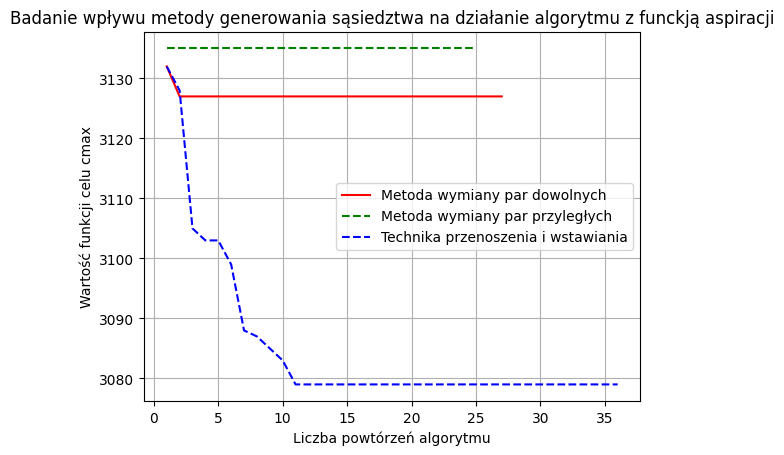

Przetwarzanie pliku data.19
Algorytm NEH: Cmax=5219.0
Algorytm TabuSearch przy type sąsiedztwa nr=1 : Cmax=5213.0, Czas wykonywania algorytmu: 74.74944949150085s
Algorytm TabuSearch przy type sąsiedztwa nr=2 : Cmax=5214.0, Czas wykonywania algorytmu: 3.237076759338379s
Algorytm TabuSearch przy type sąsiedztwa nr=3 : Cmax=5213.0, Czas wykonywania algorytmu: 136.7155637741089s


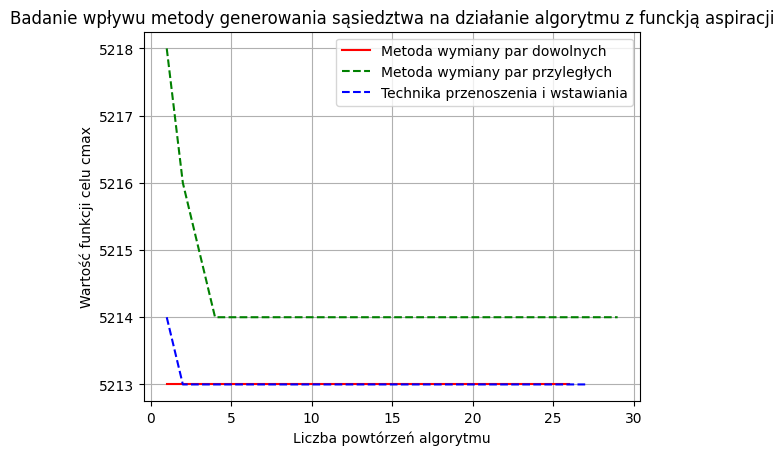

Przetwarzanie pliku data.20
Algorytm NEH: Cmax=5259.0
Algorytm TabuSearch przy type sąsiedztwa nr=1 : Cmax=5251.0, Czas wykonywania algorytmu: 74.98058819770813s
Algorytm TabuSearch przy type sąsiedztwa nr=2 : Cmax=5259.0, Czas wykonywania algorytmu: 3.072593927383423s
Algorytm TabuSearch przy type sąsiedztwa nr=3 : Cmax=5253.0, Czas wykonywania algorytmu: 139.4377043247223s


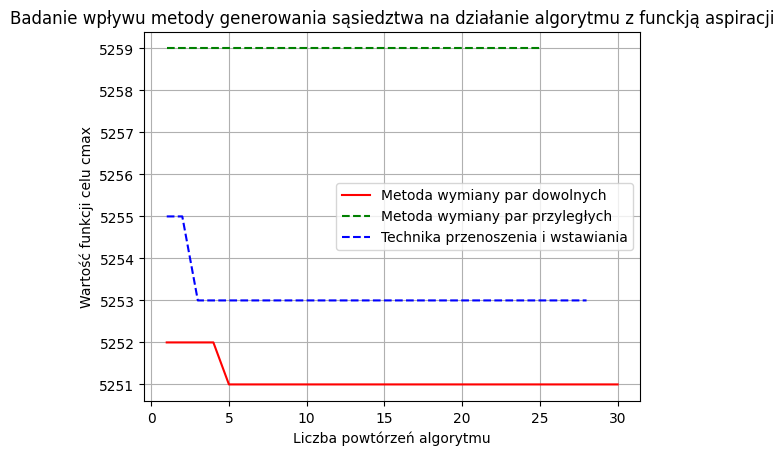

In [87]:
#BADANIE 4
#PORÓWNANIE METOD GENEROWANIA SASIĘDZTWA
#Badanie ma na celu porównanie jak na proces poszukiwania minimum lokalnego wpływają znane metody tworzenia sąsiedztwa. 
# Podczas badania mierzona będzie wartość funkcji celu dla permutacji wyznaczonej w każdej epoce oraz czas wykonywania algorytmu. 
# Dzięki temu będzie można określić, które metoda pozwala na osiągnięcie najlpszych wyników w jak najkrótszym czasie


max_epochs=100
tabuValue=7
epochs=25
N=[1,2,3]
cmax=[]

csv_file = open('Badania4-1.csv', 'w')
for i in range(1, 21):
    data = ReadData("data."+str(i))
    print("Przetwarzanie pliku data."+str(i))
    perm = NEH(data)
    S, C, CMax = Calc_CMax(perm)
    results = str(cmax)
    print("Algorytm NEH: Cmax="+str(CMax))
    cmax.clear()
    for j in range(len(N)):
        start = time.time()
        perm, buf= TabuSearch(data, max_epochs, tabuValue, epochs, aspiration=True ,neighboursType=N[j])
        end = time.time()
        S, C, CMax = Calc_CMax(perm)
        cmax.append(buf)
        results += " "+str(CMax)+" "+str(end-start)
        print("Algorytm TabuSearch przy type sąsiedztwa nr="+str(N[j])+" : Cmax="+str(CMax)+", Czas wykonywania algorytmu: "+str(end-start)+"s")
    csv_file.writelines(results+"\n")
    plt.figure()
    plt.plot(range(1,len(cmax[0])+1), cmax[0], 'r')
    plt.plot(range(1,len(cmax[1])+1), cmax[1], 'g--')
    plt.plot(range(1,len(cmax[2])+1), cmax[2], 'b--')
    plt.title("Badanie wpływu metody generowania sąsiedztwa na działanie algorytmu z funckją aspiracji")
    plt.legend(["Metoda wymiany par dowolnych", "Metoda wymiany par przyległych", "Technika przenoszenia i wstawiania"])
    plt.xlabel("Liczba powtórzeń algorytmu")
    plt.ylabel("Wartość funkcji celu cmax")
    plt.grid()
    plt.show()

csv_file.close()

Przetwarzanie pliku data.1
Algorytm NEH: Cmax=2782.0
Algorytm Branch and Bound: C_max: 3073.0, Czas wykonywania algorytmu: 0.0s
Algorytm TabuSearch z aspiracją: C_max: 2762.0, Czas wykonywania algorytmu: 11.714468717575073s
Algorytm TabuSearch bez aspiracji: C_max: 2762.0, Czas wykonywania algorytmu: 17.874924659729004s


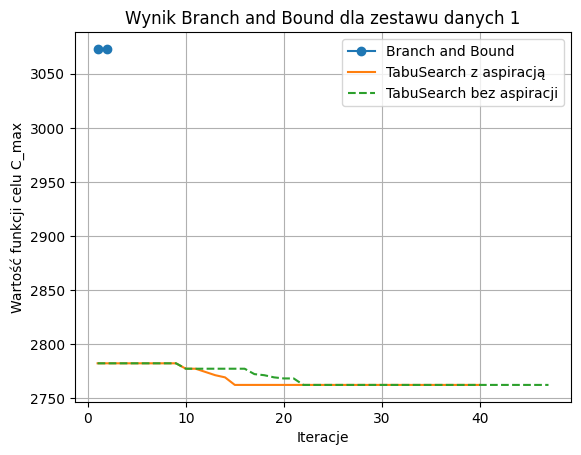

Przetwarzanie pliku data.2
Algorytm NEH: Cmax=2868.0
Algorytm Branch and Bound: C_max: 3071.0, Czas wykonywania algorytmu: 0.001049041748046875s
Algorytm TabuSearch z aspiracją: C_max: 2864.0, Czas wykonywania algorytmu: 8.075772762298584s
Algorytm TabuSearch bez aspiracji: C_max: 2864.0, Czas wykonywania algorytmu: 9.588946342468262s


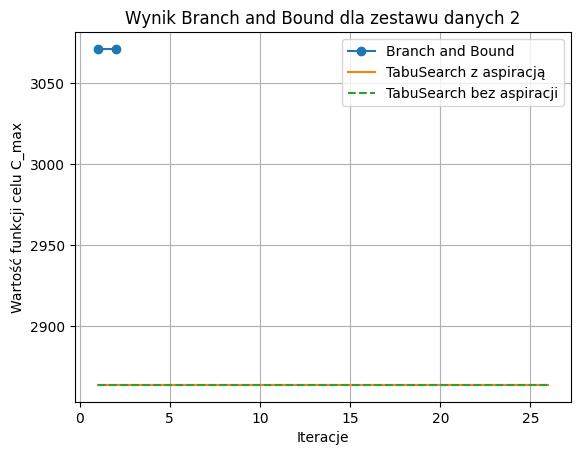

Przetwarzanie pliku data.3
Algorytm NEH: Cmax=2850.0
Algorytm Branch and Bound: C_max: 3195.0, Czas wykonywania algorytmu: 0.0009601116180419922s
Algorytm TabuSearch z aspiracją: C_max: 2836.0, Czas wykonywania algorytmu: 11.5677170753479s
Algorytm TabuSearch bez aspiracji: C_max: 2836.0, Czas wykonywania algorytmu: 9.925177335739136s


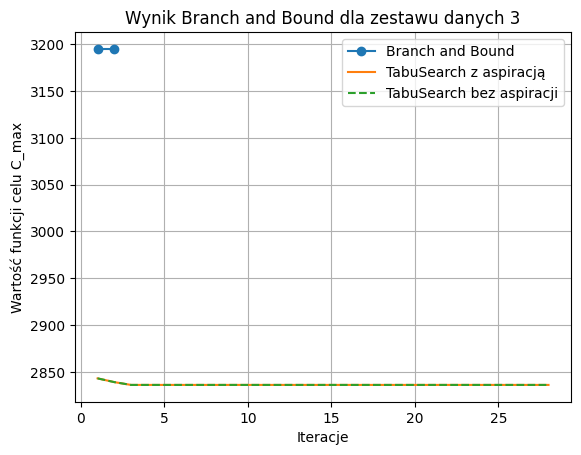

Przetwarzanie pliku data.4
Algorytm NEH: Cmax=1159.0
Algorytm Branch and Bound: C_max: 1597.0, Czas wykonywania algorytmu: 0.0s
Algorytm TabuSearch z aspiracją: C_max: 1081.0, Czas wykonywania algorytmu: 2.4005179405212402s
Algorytm TabuSearch bez aspiracji: C_max: 1081.0, Czas wykonywania algorytmu: 1.7239000797271729s


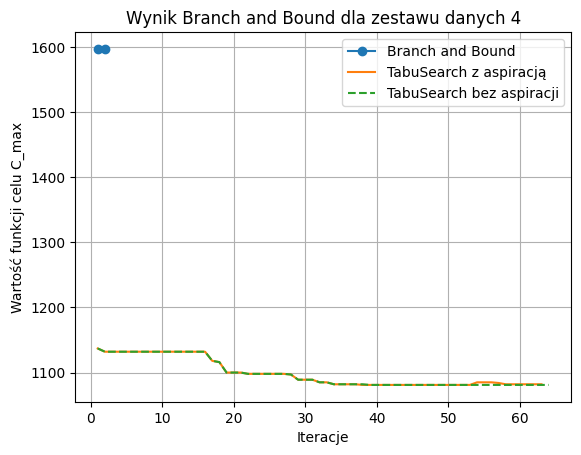

Przetwarzanie pliku data.5
Algorytm NEH: Cmax=1325.0
Algorytm Branch and Bound: C_max: 1754.0, Czas wykonywania algorytmu: 0.0009992122650146484s
Algorytm TabuSearch z aspiracją: C_max: 1301.0, Czas wykonywania algorytmu: 2.5391547679901123s
Algorytm TabuSearch bez aspiracji: C_max: 1298.0, Czas wykonywania algorytmu: 2.180842399597168s


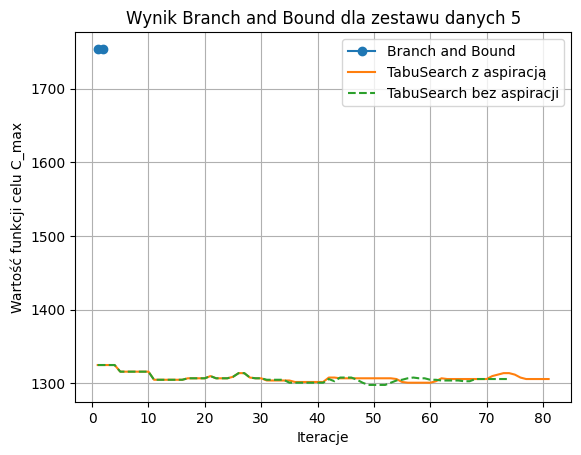

Przetwarzanie pliku data.6
Algorytm NEH: Cmax=1305.0
Algorytm Branch and Bound: C_max: 1431.0, Czas wykonywania algorytmu: 0.0s
Algorytm TabuSearch z aspiracją: C_max: 1277.0, Czas wykonywania algorytmu: 0.6185343265533447s
Algorytm TabuSearch bez aspiracji: C_max: 1277.0, Czas wykonywania algorytmu: 0.8934519290924072s


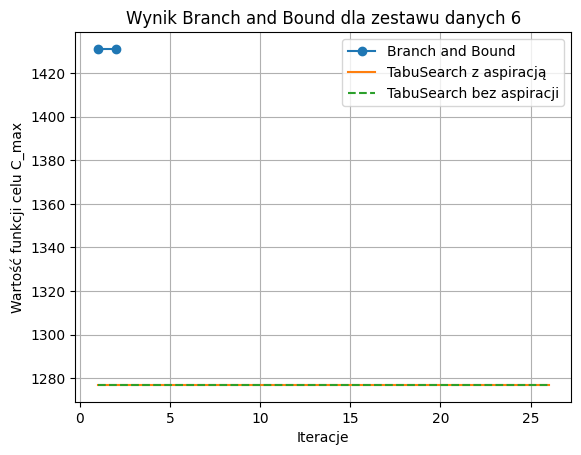

Przetwarzanie pliku data.7
Algorytm NEH: Cmax=1228.0
Algorytm Branch and Bound: C_max: 1616.0, Czas wykonywania algorytmu: 0.0s
Algorytm TabuSearch z aspiracją: C_max: 1224.0, Czas wykonywania algorytmu: 0.6333816051483154s
Algorytm TabuSearch bez aspiracji: C_max: 1224.0, Czas wykonywania algorytmu: 0.530325174331665s


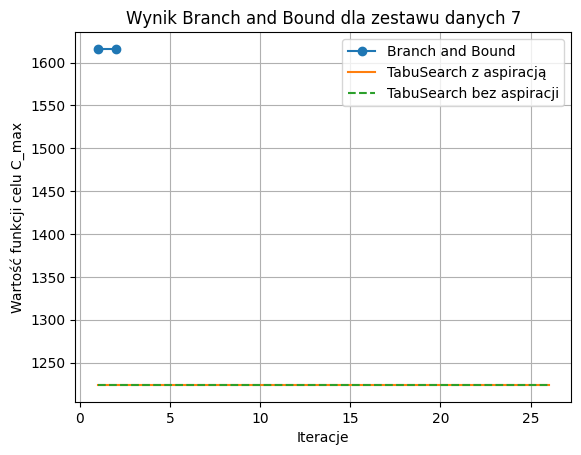

Przetwarzanie pliku data.8
Algorytm NEH: Cmax=1278.0
Algorytm Branch and Bound: C_max: 1528.0, Czas wykonywania algorytmu: 0.0s
Algorytm TabuSearch z aspiracją: C_max: 1251.0, Czas wykonywania algorytmu: 0.5487279891967773s
Algorytm TabuSearch bez aspiracji: C_max: 1251.0, Czas wykonywania algorytmu: 0.5082402229309082s


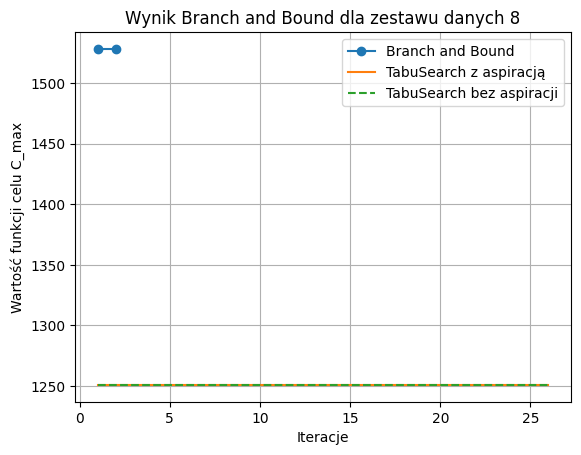

Przetwarzanie pliku data.9
Algorytm NEH: Cmax=1223.0
Algorytm Branch and Bound: C_max: 1428.0, Czas wykonywania algorytmu: 0.0009961128234863281s
Algorytm TabuSearch z aspiracją: C_max: 1207.0, Czas wykonywania algorytmu: 0.7335841655731201s
Algorytm TabuSearch bez aspiracji: C_max: 1207.0, Czas wykonywania algorytmu: 1.0872228145599365s


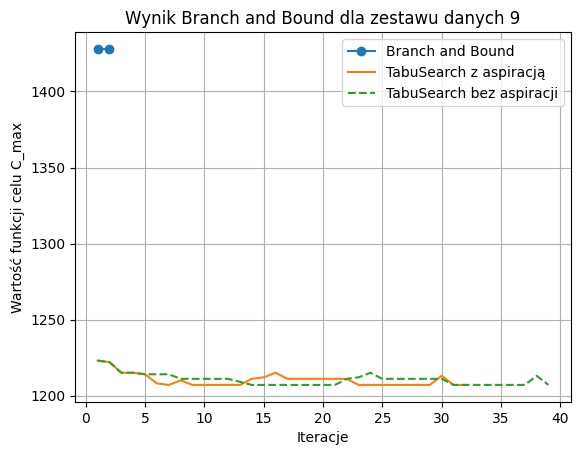

Przetwarzanie pliku data.10
Algorytm NEH: Cmax=1291.0
Algorytm Branch and Bound: C_max: 1468.0, Czas wykonywania algorytmu: 0.0009970664978027344s
Algorytm TabuSearch z aspiracją: C_max: 1253.0, Czas wykonywania algorytmu: 1.6837921142578125s
Algorytm TabuSearch bez aspiracji: C_max: 1253.0, Czas wykonywania algorytmu: 1.4323720932006836s


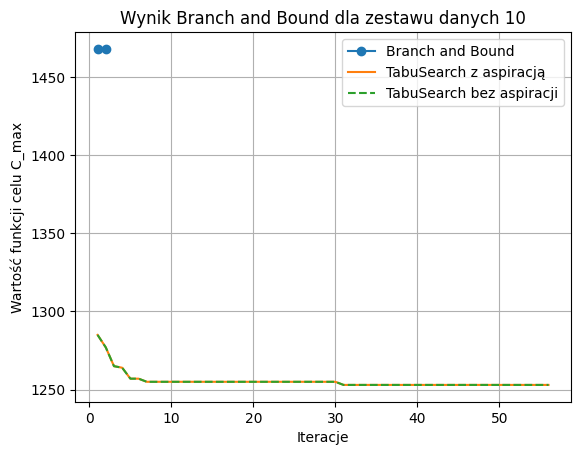

In [111]:
#BADANIE 5
#PORÓWNANIE CZASU PRACY ORAZ WYNIKÓW ALGORYTMU TABUSEARCH Z ALGORYTMEM BRANCH AND BOUND

max_epochs=100
tabuValue= 7
epochs=25
buffer1=[]
buffer2=[]

for i in range(1, 11):
    data = ReadData("data."+str(i))
    print("Przetwarzanie pliku data."+str(i))
    perm = NEH(data)
    S, C, CMax = Calc_CMax(perm)
    results = str(cmax)
    print("Algorytm NEH: Cmax="+str(CMax))
    cmax.clear

    start = time.time()
    perm, cmax_value, cmax_history = BranchAndBound(data)
    #perm, cmax_value, cmax_history = BranchAndBoundWithNEH(data)
    end = time.time()
    print("Algorytm Branch and Bound: C_max: "+str(cmax_value)+", Czas wykonywania algorytmu: "+str(end-start)+"s")

    buffer1.clear()
    buffer2.clear()
    start = time.time()
    perm, buffer1 = TabuSearch(data, max_epochs, tabuValue, epochs, True)
    end = time.time()
    S, C, CMax = Calc_CMax(perm)
    cmax.append(buffer1)
    print("Algorytm TabuSearch z aspiracją: C_max: "+str(CMax)+", Czas wykonywania algorytmu: "+str(end-start)+"s")


    start = time.time()
    perm, buffer2 = TabuSearch(data, max_epochs, tabuValue, epochs, False)
    end = time.time()
    S, C, CMax = Calc_CMax(perm)
    cmax.append(buffer2)
    print("Algorytm TabuSearch bez aspiracji: C_max: "+str(CMax)+", Czas wykonywania algorytmu: "+str(end-start)+"s")


    plt.figure()
    plt.plot(range(1, len(cmax_history)+1), cmax_history, marker='o', linestyle='-') 
    plt.plot(range(1,len(buffer1)+1), buffer1)
    plt.plot(range(1,len(buffer2)+1), buffer2, linestyle='--')
    plt.title(f"Wynik Branch and Bound dla zestawu danych {i}")
    plt.legend(["Branch and Bound", "TabuSearch z aspiracją", "TabuSearch bez aspiracji"])
    plt.xlabel("Iteracje")
    plt.ylabel("Wartość funkcji celu C_max")
    plt.grid()
    plt.show()

    #WNIOSKI
    #Porównując wyniki dla TabuSearch'a z aspiracją, bez aspiracji oraz algorytmu Branch and Bound możemy stwierdzić,
    #że najlepsze wyniki daje nam TabuSearch z aspiracją. Algorytm dokładny w tym przypadku Branch and Bound niezależnie
    #czy wspomagany algorytmem NEH, deterministyczną permutacją czy losową permutacją za każdym razem daje nam gorszy wynik
    #od TabuSearcha. 

    #Dokładniejsza analiza działania Branch and Bound:
    #W sytuacji gdy wykrozystujemy algorytm NEH, algorytm Branch and Bound nie znajduje lepszego rozwiązania dla Cmax.
    #Gdy wykorzystujemy deterministyczną permutacje algorytm działa szybko i przewidywalnie ale może nie być efektywny w eksploracji 
    #przestrzeni rozwiązań, jeśli naturalny porządek zadań nie jest bliski optymalnemu. Z kolei gdy wykorzystujemy
    #losowe permutacje algorytm może lepiej eksplorować przestrzeń rozwiązań, ale wyniki będą różnić się przy każdym 
    #uruchomieniu, co może wpływać na konsekwencję wyników.

    #PODSUMOWANIE BADANIA
    #Najlepszy wynik Branch and Bound daje w momencie wykorzystania algorytmu NEH, przy pozostałych modyfikacjach permutacji
    #Wyniki znacząco odbiegają od wyników TabuSearch'a.
